### Load the dataset

In [10]:
from models import ClaimsDataset, Claim

with open("data/claims_dataset_v2_manual.json", "r") as f:
    dataset = ClaimsDataset.model_validate_json(f.read())
print(len(dataset.root))

400


In [12]:
help(Claim)

Help on class Claim in module models:

class Claim(pydantic.main.BaseModel)
 |  Claim(*, description: str, explanation: str, coverage: bool, sources: list[models.Source], source_rule: models.SourceRuleContainer, limit_unit: str | None = None, limit_amount: float | None = None, limit_targets: list[str]) -> None
 |
 |  Represents an individual insurance claim with all its details and
 |  associated rules.
 |
 |  Attributes:
 |      description (str): Detailed description of the claim scenario
 |      explanation (str): Additional explanation or notes about the claim
 |      coverage (bool): Whether the claim is covered under the policy
 |      sources (list[Source]): Relevant policy document excerpts supporting
 |          the claim
 |      source_rule (SourceRuleContainer): Collection of rules applicable to
 |          the claim
 |      limit_unit (Optional[str]): Currency unit for the claim limit (e.g.,
 |          "GBP")
 |      limit_amount (Optional[float]): Maximum amount covered f

In [44]:
# claim covered
len([claim for claim in dataset.root if claim.coverage]), len([claim for claim in dataset.root if claim.coverage]) / len(dataset.root)

(126, 0.315)

In [45]:
# claim not covered
len([claim for claim in dataset.root if not claim.coverage]), len([claim for claim in dataset.root if not claim.coverage]) / len(dataset.root)

(274, 0.685)

68.5% of claims are not covered, 31.5% are covered 

### Split Train / Test

In [13]:
import random

# Seed for reproducibility
random.seed(42)

# shuffle the dataset
# we could use a stratified split to make sure we have 
# the same proportion of covered and not covered claims in the train and test set
random.shuffle(dataset.root)
train_size = int(len(dataset.root) * 0.8)
train_dataset: list[Claim] = dataset.root[:train_size]
test_dataset: list[Claim] = dataset.root[train_size:]

len(train_dataset), len(test_dataset)

(320, 80)

In [46]:
len([claim for claim in test_dataset if claim.coverage]), len([claim for claim in test_dataset if claim.coverage]) / len(test_dataset)

(28, 0.35)

In [48]:
len([claim for claim in test_dataset if not claim.coverage]), len([claim for claim in test_dataset if not claim.coverage]) / len(test_dataset)

(52, 0.65)

### Establish baseline performance Qwen2.5(3B)

In [1]:
import torch
print(f"CUDA version: {torch.version.cuda}")

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Get the current device info if CUDA is available
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

CUDA version: 12.4
CUDA available: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 2070


In [2]:
from unsloth import FastLanguageModel

Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/models/llama.py:1859: SyntaxWarning: invalid escape sequence '\.'
  start = re.search('logger\.info\([\"\'].+?Running training', inner_training_loop).span(0)[0]
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/models/llama.py:1862: SyntaxWarning: invalid escape sequence '\s'
  spaces = re.search('\n([\s\t]{1,})', original_debug).group(0)[1:]
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/models/llama.py:1863: SyntaxWarning: invalid escape sequence '\s'
  front_spaces = re.match('([\s\t]{1,})', inner_training_loop).group(0)
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/models/_utils.py:584: SyntaxWarning: invalid escape sequence '\.'
  source = re.sub("([^\.])nn\.", r"\1torch.nn.", source)
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/models/_utils.py:847: SyntaxWarning: invalid escape sequenc

🦥 Unsloth Zoo will now patch everything to make training faster!


/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/save.py:481: SyntaxWarning: invalid escape sequence '\s'
  gb_found = re.match("([0-9]{1,})[\s]{0,}GB", max_shard_size, flags = re.IGNORECASE)
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/save.py:482: SyntaxWarning: invalid escape sequence '\s'
  mb_found = re.match("([0-9]{1,})[\s]{0,}MB", max_shard_size, flags = re.IGNORECASE)
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/save.py:1011: SyntaxWarning: invalid escape sequence '\ '
  f"   \\\   /|    [0] Installing llama.cpp might take 3 minutes.\n"\
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/save.py:1012: SyntaxWarning: invalid escape sequence '\_'
  f"O^O/ \_/ \\    [1] Converting HF to GGUF 16bits might take 3 minutes.\n"\
/home/guillaume/Projects/AMLD2025/.venv/lib/python3.12/site-packages/unsloth/save.py:1013: SyntaxWarning: invalid escape sequence '\ '
  f"\  

INFO 02-10 11:07:11 __init__.py:190] Automatically detected platform cuda.


In [4]:
from unsloth import is_bfloat16_supported
import torch

max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-3B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.5, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

==((====))==  Unsloth 2025.2.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA GeForce RTX 2070. Max memory: 7.607 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 43.61%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 7.61 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 0.9 GB. Also swap space = 5 GB.
WARNING 02-10 11:08:28 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-10 11:08:35 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'generate', 'score', '

tokenizer_config.json:   0%|          | 0.00/7.36k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

INFO 02-10 11:08:40 cuda.py:179] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 02-10 11:08:40 cuda.py:227] Using XFormers backend.
INFO 02-10 11:08:41 model_runner.py:1110] Starting to load model unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit...
INFO 02-10 11:08:41 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 02-10 11:08:42 weight_utils.py:252] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/2.36G [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-10 11:10:07 model_runner.py:1115] Loading model weights took 2.2265 GB
INFO 02-10 11:10:07 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-10 11:10:12 worker.py:267] Memory profiling takes 4.79 seconds
INFO 02-10 11:10:12 worker.py:267] the current vLLM instance can use total_gpu_memory (7.61GiB) x gpu_memory_utilization (0.44) = 3.32GiB
INFO 02-10 11:10:12 worker.py:267] model weights take 2.23GiB; non_torch_memory takes -0.07GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.46GiB.
INFO 02-10 11:10:13 executor_base.py:110] # CUDA blocks: 830, # CPU blocks: 9102
INFO 02-10 11:10:13 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 12.97x
INFO 02-10 11:10:19 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occu

Capturing CUDA graph shapes: 100%|██████████| 19/19 [00:14<00:00,  1.35it/s]

INFO 02-10 11:10:33 model_runner.py:1562] Graph capturing finished in 14 secs, took 0.47 GiB
INFO 02-10 11:10:33 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 25.56 seconds



Unsloth 2025.2.5 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [14]:
claim = test_dataset[0]
claim

Claim(description="I discovered someone had attempted to steal my car. The driver's side door lock was damaged, and the dashboard was dismantled, with the stereo missing. Is there any provision for covering transportation and accomodation?", explanation='', coverage=False, sources=[Source(paragraph='If your car, accessories or spare parts are lost, stolen or damaged, we will: - repair the damage; - replace what is lost or damaged and is too expensive to repair; or - pay you the cost of the loss or damage.', file_name='', page=13, line=0), Source(paragraph='If your car is damaged, we will use one of our recommended repairers to repair it. If you choose not to use them, we may not pay more than our recommended repairer would have charged and we may choose to settle the claim by a financial payment. Following damage to your car, we may move your car to a place of safe and free storage pending settlement of any claim.', file_name='', page=13, line=0), Source(paragraph='Where your car is no

In [18]:
[source.paragraph for source in claim.sources]

['If your car, accessories or spare parts are lost, stolen or damaged, we will: - repair the damage; - replace what is lost or damaged and is too expensive to repair; or - pay you the cost of the loss or damage.',
 'If your car is damaged, we will use one of our recommended repairers to repair it. If you choose not to use them, we may not pay more than our recommended repairer would have charged and we may choose to settle the claim by a financial payment. Following damage to your car, we may move your car to a place of safe and free storage pending settlement of any claim.',
 'Where your car is not recovered following a theft or is beyond economical repair we will pay you the market value of your car, including accessories and spare parts at the time they are lost, stolen or damaged.',
 'If we settle a claim as a total loss, we will then take ownership of your car.',
 'Accessories and spare parts of your car, which are in your private garage at the time of their loss or damage, will a

In [27]:
prompts = []
for claim in test_dataset:
    text = tokenizer.apply_chat_template(
        [
            {
                "role" : "user",
                "content" : f"""
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy.

Claim description:
{claim.description}

Sources:
{[source.paragraph for source in claim.sources]}

Format:
Return only "covered" or "not covered"
""".strip()
            },
    ], tokenize = False, add_generation_prompt = True)
    prompts.append(text)

print(prompts[0])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy.

Claim description:
I discovered someone had attempted to steal my car. The driver's side door lock was damaged, and the dashboard was dismantled, with the stereo missing. Is there any provision for covering transportation and accomodation?

Sources:
['If your car, accessories or spare parts are lost, stolen or damaged, we will: - repair the damage; - replace what is lost or damaged and is too expensive to repair; or - pay you the cost of the loss or damage.', 'If your car is damaged, we will use one of our recommended repairers to repair it. If you choose not to use them, we may not pay more than our recommended repairer would have charged and we may choose to settle the claim

In [24]:
# to set our sampling parameters its important we check how much token is "covered" and "not covered"
# tokenizer usually use bpe bit piece encoding algorithm to create tokens on a dataset
# see this great video from Andrej Karpathy to understand how bpe works:

print(f"num tokens covered: {len(tokenizer.tokenize('covered'))}")
print(f"num tokens not covered: {len(tokenizer.tokenize('not covered'))}")

num tokens covered: 1
num tokens not covered: 2


In [28]:
from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 2, # set to 2 as not covered is 2 tokens
)
outputs = model.fast_generate(
    prompts,
    sampling_params = sampling_params,
    lora_request = None,
)


Processed prompts: 100%|██████████| 80/80 [00:09<00:00,  8.83it/s, est. speed input: 3182.32 toks/s, output: 17.67 toks/s]


In [49]:
responses = []
for response_output in output:
    responses.append(response_output.outputs[0].text)

responses

['not covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'not covered',
 'covered',
 'covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'not covered',
 'no

In [52]:
print(f"Predicted {len([response for response in responses if response == 'covered'])} claims as covered")
print(f"Predicted {len([response for response in responses if response == 'not covered'])} claims as not covered")


Predicted 22 claims as covered
Predicted 58 claims as not covered


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = [response.strip() == 'covered' for response in responses]
y_true = [claim.coverage for claim in test_dataset]
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")


Accuracy: 0.75
Precision: 0.6818181818181818
Recall: 0.5357142857142857
F1 Score: 0.6


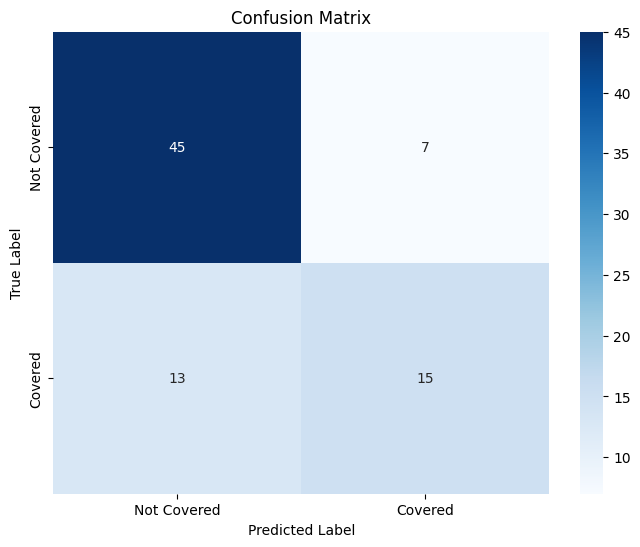

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert responses to boolean (True for 'covered', False for 'not covered')
y_pred = [response.strip() == 'covered' for response in responses]
y_true = [claim.coverage for claim in test_dataset]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Covered', 'Covered'],
            yticklabels=['Not Covered', 'Covered'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()